In [ ]:
import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)
!mv /content/kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0


In [ ]:
!unzip /content/gtsrb-german-traffic-sign.zip -d /content/GTSRB_Data

Streaming output truncated to the last 5000 lines.
  inflating: /content/GTSRB_Data/train/5/00005_00053_00010.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00011.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00012.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00013.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00014.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00015.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00016.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00017.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00018.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00019.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00020.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00021.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00022.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00023.png  
  inflating: /content/GTSRB_Data/train/

In [ ]:
import os

# List the files inside the extracted dataset folder
print(os.listdir("/content/GTSRB_Data"))

['Meta.csv', 'Train.csv', 'meta', 'train', 'test', 'Test', 'Train', 'Meta', 'Test.csv']


- <b>Train</b>/ → Contains traffic sign images categorized into subfolders (each folder represents a class).

- <b>Test</b>/ → Contains test images.

- <b>Meta/classes.csv</b> → Contains label mappings.

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


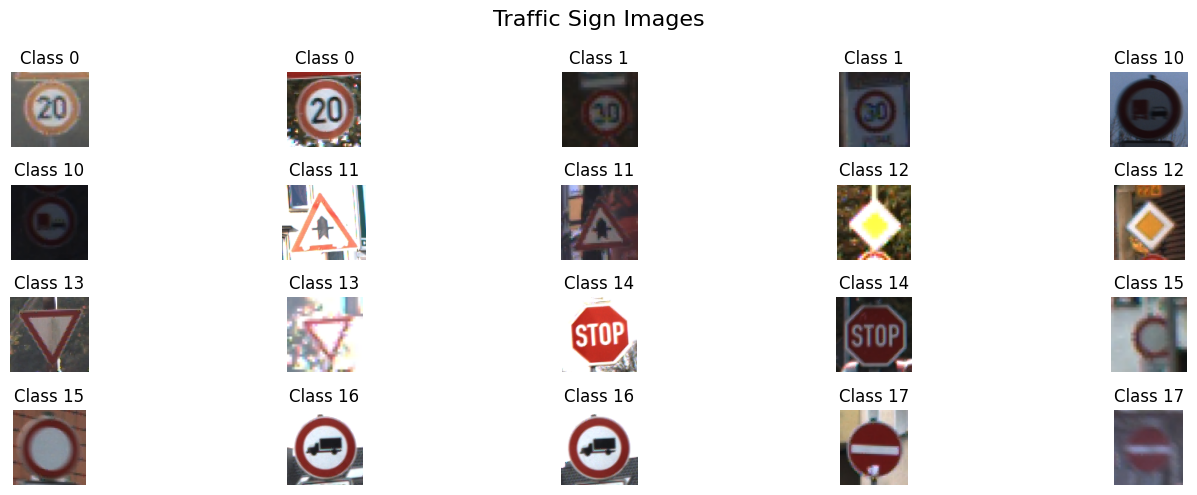

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os


dataset_path = "/content/GTSRB_Data/Train/"


class_folders = sorted(os.listdir(dataset_path))
print(class_folders)

# Initialize an empty list to store image file paths
image_files = []

# Loop through the first few class folders and get image paths
for class_folder in class_folders[:10]:
    class_path = os.path.join(dataset_path, class_folder) # -------------
                                                                        #|
    if os.path.isdir(class_path):                                       #| - Here path join ka mtlb -> getting the
        for img_file in os.listdir(class_path)[:2]:                     #|   information about the whole path and
            image_files.append(os.path.join(class_path, img_file)) # ----    structuring it taki baad me sahi chale.


#print(image_files)
if len(image_files) == 0:
    print(f"No images found in {dataset_path}!")
else:
    num_images = len(image_files)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
    fig.suptitle("Traffic Sign Images", fontsize=16)

    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, img_path in enumerate(image_files):
        img = cv2.imread(img_path)

        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Class {os.path.basename(os.path.dirname(img_path))}")
    for j in range(i+1, len(axes)):
        fig.axes("off")
    plt.tight_layout()
    plt.show()



In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm

# Define Paths
train_dir = "/content/GTSRB_Data/Train"
test_dir = "//content/GTSRB_Data/Test"
train_csv_path = "/content/GTSRB_Data/Train.csv"
test_csv_path = "/content/GTSRB_Data/Test.csv"

# Function to Load Bounding Boxes from CSV
def load_bbox_data(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}

    for _, row in df.iterrows():
        filename = os.path.basename(row["Path"])  # Extract filename
        class_id = int(row["ClassId"])
        x_min, y_min, x_max, y_max = row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]

        # Normalize bounding box for YOLO format
        img_width, img_height = row["Width"], row["Height"]
        x_center = ((x_min + x_max) / 2) / img_width
        y_center = ((y_min + y_max) / 2) / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        # Store in dictionary
        bbox_dict[filename] = [class_id, x_center, y_center, width, height]

    print(f"Loaded {len(bbox_dict)} bounding boxes from {csv_path}")
    return bbox_dict

# Load Bounding Box Data
train_bbox_dict = load_bbox_data(train_csv_path)
test_bbox_dict = load_bbox_data(test_csv_path)


Loaded 39209 bounding boxes from /content/GTSRB_Data/Train.csv
Loaded 12630 bounding boxes from /content/GTSRB_Data/Test.csv


In [ ]:
# Function to Load Images & Assign Bounding Boxes
def load_images_and_labels(image_dir, bbox_dict):
    images, labels = [], []

    for class_folder in sorted(os.listdir(image_dir)):  # Iterate over class folders
        class_path = os.path.join(image_dir, class_folder)

        if os.path.isdir(class_path):
            for img_file in tqdm(os.listdir(class_path), desc=f"Processing {class_folder}"):
                img_path = os.path.join(class_path, img_file)

                # Read & Preprocess Image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (64, 64))  # Resize to 64x64
                img = img / 255.0  # Normalize

                images.append(img)

                # Get bounding box
                if img_file in bbox_dict:
                    labels.append(bbox_dict[img_file])
                else:
                    print(f"⚠ Warning: No bbox found for {img_file}, assigning default bbox.")
                    labels.append([0, 0.5, 0.5, 0.5, 0.5])  # Default bbox if missing

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)

# Load Train & Test Data
X_train, y_train = load_images_and_labels(train_dir, train_bbox_dict)
X_test, y_test = load_images_and_labels(test_dir, test_bbox_dict)


Processing 9: 100%|██████████| 1470/1470 [00:00<00:00, 2576.29it/s]


In [ ]:
from sklearn.model_selection import train_test_split

# Split Training Data (80% Train, 20% Validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Train Set: {X_train.shape[0]} images, Validation Set: {X_val.shape[0]} images")


Train Set: 31367 images, Validation Set: 7842 images


In [ ]:
np.save("/content/Checkpt_1/X_train.npy", X_train)
np.save("/content/Checkpt_1/y_train.npy", y_train)
np.save("/content/Checkpt_1/X_val.npy", X_val)
np.save("/content/Checkpt_1/y_val.npy", y_val)
np.save("/content/Checkpt_1/X_test.npy", X_test)
np.save("/content/Checkpt_1/y_test.npy", y_test)

print("Processed datasets saved successfully!")


Processed datasets saved successfully!


In [ ]:
import albumentations as A
import os

In [ ]:
# Define Augmentation Pipeline
augmentations = A.Compose([
    A.Resize(64, 64, always_apply=True),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),
])

<ipython-input-11-2ea30c3e4071>:3: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(64, 64, always_apply=True),


In [ ]:
# Function to Apply Augmentations
def augment_and_save(images, labels, save_dir, prefix="aug_"):
    os.makedirs(save_dir, exist_ok=True)
    augmented_images, augmented_labels = [], []

    for i in tqdm(range(len(images)), desc="Augmenting Images"):
        img = images[i]
        label = labels[i]

        # Convert grayscale images to RGB
        img = (img * 255).astype(np.uint8)
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Apply Augmentations
        augmented = augmentations(image=img)
        aug_img = augmented["image"]

        # Resize Image
        aug_img = cv2.resize(aug_img, (64, 64))

        # Save Augmented Image
        img_path = os.path.join(save_dir, f"{prefix}{i}.jpg")
        cv2.imwrite(img_path, aug_img)

        augmented_images.append(aug_img / 255.0)  # Normalize
        augmented_labels.append(label)

    return np.array(augmented_images, dtype=np.float32), np.array(augmented_labels, dtype=np.float32)


In [ ]:
aug_save_dir = "/content/Augmented_Train"
X_train_aug, y_train_aug = augment_and_save(X_train, y_train, save_dir=aug_save_dir)

Augmenting Images: 100%|██████████| 31367/31367 [00:26<00:00, 1197.17it/s]


In [ ]:
np.save("/content/Checkpt_2/X_train_aug.npy", X_train_aug)
np.save("/content/Checkpt_2/y_train_aug.npy", y_train_aug)

print("Augmented dataset saved successfully!")


Augmented dataset saved successfully!


Bringing in the Data and Converting it to YOLO format

In [ ]:
import os
import numpy as np

# Paths for saving YOLO labels
yolo_labels_dir = "/content/YOLO_Labels"
os.makedirs(yolo_labels_dir, exist_ok=True)

# Function to Convert Labels to YOLO Format
def convert_to_yolo(labels, save_dir, prefix="train_"):
    for i, label in enumerate(labels):
        class_id, x_center, y_center, width, height = label
        label_file = os.path.join(save_dir, f"{prefix}{i}.txt")

        with open(label_file, "w") as f:
            f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Convert Train & Augmented Train Labels
convert_to_yolo(y_train, yolo_labels_dir, prefix="train_")
convert_to_yolo(y_train_aug, yolo_labels_dir, prefix="aug_train_")

print(f"Converted {len(y_train) + len(y_train_aug)} labels to YOLO format!")


Converted 62734 labels to YOLO format!


In [ ]:
import os
import numpy as np

# Paths for saving YOLO labels
yolo_labels_dir = "/content/YOLO_Labels"
os.makedirs(yolo_labels_dir, exist_ok=True)

# Function to Convert Labels to YOLO Format & Save as `.npy`
def convert_and_save_yolo(labels, save_dir, npy_path, prefix="train_"):
    yolo_labels = []

    for i, label in enumerate(labels):
        class_id, x_center, y_center, width, height = label
        yolo_labels.append([class_id, x_center, y_center, width, height])

        # Save as .txt (for YOLO training)
        label_file = os.path.join(save_dir, f"{prefix}{i}.txt")
        with open(label_file, "w") as f:
            f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    # Save as .npy file for future use
    np.save(npy_path, np.array(yolo_labels, dtype=np.float32))

# Convert & Save Train Labels
convert_and_save_yolo(y_train, yolo_labels_dir, "/content/Checkpt_3/y_train_yolo.npy", prefix="train_")

# Convert & Save Augmented Train Labels
convert_and_save_yolo(y_train_aug, yolo_labels_dir, "/content/Checkpt_3/y_train_aug_yolo.npy", prefix="aug_train_")

print(f"Saved {len(y_train) + len(y_train_aug)} YOLO labels in .npy format for safety!")


Saved 62734 YOLO labels in .npy format for safety!


In [ ]:
dataset_yaml = """
path: /content
train: YOLO_Labels  # Folder containing training labels
val: YOLO_Labels  # Using the same for validation
nc: 43  # Number of traffic sign classes
names: ['Speed Limit 20', 'Speed Limit 30', 'Speed Limit 50', 'Speed Limit 60',
        'Speed Limit 70', 'Speed Limit 80', 'End of Speed Limit 80', 'Speed Limit 100',
        'Speed Limit 120', 'No Overtaking', 'No Overtaking Trucks', 'Right of Way Intersection',
        'Priority Road', 'Yield', 'Stop', 'No Vehicles', 'No Trucks', 'No Entry',
        'Caution', 'Dangerous Left Curve', 'Dangerous Right Curve', 'Double Curve',
        'Bumpy Road', 'Slippery Road', 'Road Narrows on Right', 'Road Work',
        'Traffic Signals', 'Pedestrian Crossing', 'Children Crossing', 'Bicycles Crossing',
        'Snow Warning', 'Deer Warning', 'End of Speed & Overtaking Limits', 'Turn Right',
        'Turn Left', 'Ahead Only', 'Go Right or Straight', 'Go Left or Straight',
        'Keep Right', 'Keep Left', 'Roundabout Mandatory', 'End of No Passing',
        'End of No Passing for Trucks']
"""

# Save dataset.yaml
with open("/content/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("dataset.yaml file created!")


dataset.yaml file created!


In [ ]:
import numpy as np

# Reload Training Data
X_train = np.load("/kaggle/input/files-traffic-data/Chkpt1/X_train.npy")
y_train = np.load("/kaggle/input/files-traffic-data/Chkpt1/y_train.npy")

# Reload Validation Data
X_val = np.load("/kaggle/input/files-traffic-data/Chkpt1/X_val.npy")
y_val = np.load("/kaggle/input/files-traffic-data/Chkpt1/y_val.npy")

# Reload Test Data
X_test = np.load("/kaggle/input/files-traffic-data/Chkpt1/X_test.npy")
y_test = np.load("/kaggle/input/files-traffic-data/Chkpt1/y_test.npy")

# Reload Augmented Training Data
X_train_aug = np.load("/kaggle/input/files-traffic-data/Chkpt2/X_train_aug.npy")
y_train_aug = np.load("/kaggle/input/files-traffic-data/Chkpt2/y_train_aug.npy")

# Reload YOLO-Formatted Labels
y_train_yolo = np.load("/kaggle/input/files-traffic-data/Chkpt3/y_train_yolo.npy")
y_train_aug_yolo = np.load("/kaggle/input/files-traffic-data/Chkpt3/y_train_aug_yolo.npy")

print("All datasets reloaded successfully!")


All datasets reloaded successfully!


In [ ]:
import os

# Paths for saving YOLO labels
yolo_labels_dir = "/kaggle/working//YOLO_Labels"
os.makedirs(yolo_labels_dir, exist_ok=True)

# Function to Recreate YOLO `.txt` Files from `.npy`
def recreate_yolo_txt(labels, save_dir, prefix="train_"):
    for i, label in enumerate(labels):
        class_id, x_center, y_center, width, height = label
        label_file = os.path.join(save_dir, f"{prefix}{i}.txt")

        with open(label_file, "w") as f:
            f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Recreate Training & Augmented YOLO Labels
recreate_yolo_txt(y_train_yolo, yolo_labels_dir, prefix="train_")
recreate_yolo_txt(y_train_aug_yolo, yolo_labels_dir, prefix="aug_train_")

print("YOLO `.txt` label files recreated successfully!")


YOLO `.txt` label files recreated successfully!


In [ ]:
import os

print("Sample YOLO Labels:")
txt_files = os.listdir(yolo_labels_dir)[:5]  # Print first 5 label files
for file in txt_files:
    with open(os.path.join(yolo_labels_dir, file), "r") as f:
        print(f"{file}: {f.readline().strip()}")


Sample YOLO Labels:
aug_train_17232.txt: 38 0.500000 0.500000 0.827586 0.841270
aug_train_27151.txt: 38 0.500000 0.514706 0.696970 0.676471
aug_train_19476.txt: 3 0.516129 0.516667 0.645161 0.633333
aug_train_6074.txt: 19 0.513158 0.514286 0.710526 0.685714
aug_train_4163.txt: 18 0.514706 0.515625 0.676471 0.656250


In [ ]:
import os
import shutil

# Define YOLO Dataset Paths
yolo_dataset_dir = "/kaggle/working/YOLO_Dataset"
train_img_dir = os.path.join(yolo_dataset_dir, "images/train")
val_img_dir = os.path.join(yolo_dataset_dir, "images/val")
train_label_dir = os.path.join(yolo_dataset_dir, "labels/train")
val_label_dir = os.path.join(yolo_dataset_dir, "labels/val")

# Create directories if they don't exist
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)



In [ ]:
import cv2
# Move Training Images
for i, img in enumerate(X_train):
    img_path = os.path.join(train_img_dir, f"train_{i}.jpg")
    cv2.imwrite(img_path, (img * 255).astype(np.uint8))  # Convert back to uint8 & save

# Move Validation Images
for i, img in enumerate(X_val):
    img_path = os.path.join(val_img_dir, f"val_{i}.jpg")
    cv2.imwrite(img_path, (img * 255).astype(np.uint8))

# Move Training Labels
for i, label in enumerate(y_train_yolo):
    label_path = os.path.join(train_label_dir, f"train_{i}.txt")
    with open(label_path, "w") as f:
        f.write(f"{int(label[0])} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

# Move Validation Labels
for i, label in enumerate(y_val):
    label_path = os.path.join(val_label_dir, f"val_{i}.txt")
    with open(label_path, "w") as f:
        f.write(f"{int(label[0])} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

print("Images & labels moved to YOLO dataset structure!")


Images & labels moved to YOLO dataset structure!


In [ ]:
import shutil

# Source file (inside read-only /kaggle/input/)
source_file = "/kaggle/input/files-traffic-data/dataset.yaml"

# Destination file (inside writable /kaggle/working/)
destination_file = "/kaggle/working/dataset.yaml"

# Copy the file
shutil.copy(source_file, destination_file)

print("File copied successfully! Now you can edit it.")

File copied successfully! Now you can edit it.


In [ ]:
dataset_yaml = """
path: /kaggle/working/YOLO_Dataset  # Root dataset directory
train: images/train  # Training images folder
val: images/val  # Validation images folder
nc: 43  # Number of traffic sign classes
names: ['Speed Limit 20', 'Speed Limit 30', 'Speed Limit 50', 'Speed Limit 60',
        'Speed Limit 70', 'Speed Limit 80', 'End of Speed Limit 80', 'Speed Limit 100',
        'Speed Limit 120', 'No Overtaking', 'No Overtaking Trucks', 'Right of Way Intersection',
        'Priority Road', 'Yield', 'Stop', 'No Vehicles', 'No Trucks', 'No Entry',
        'Caution', 'Dangerous Left Curve', 'Dangerous Right Curve', 'Double Curve',
        'Bumpy Road', 'Slippery Road', 'Road Narrows on Right', 'Road Work',
        'Traffic Signals', 'Pedestrian Crossing', 'Children Crossing', 'Bicycles Crossing',
        'Snow Warning', 'Deer Warning', 'End of Speed & Overtaking Limits', 'Turn Right',
        'Turn Left', 'Ahead Only', 'Go Right or Straight', 'Go Left or Straight',
        'Keep Right', 'Keep Left', 'Roundabout Mandatory', 'End of No Passing',
        'End of No Passing for Trucks']
"""

# Save dataset.yaml
with open("/kaggle/working/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("dataset.yaml updated for YOLO training!")


dataset.yaml updated for YOLO training!


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# Load YOLOv8 Model
model = YOLO("yolov8s.pt")  # Small model, you can use 'yolov8m.pt' or 'yolov8l.pt' for better accuracy

# Train YOLOv8
model.train(
    data="/kaggle/working/dataset.yaml",  # Updated path
    epochs=50,
    batch=16,
    imgsz=64,
    device="cuda",
    patience = 10
)

Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /kaggle/working/YOLO_Dataset/labels/train.cache... 31367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31367/31367 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/YOLO_Dataset/labels/val.cache... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.525G      0.995      2.341      1.086         19         64: 100%|██████████| 1961/1961 [02:30<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:28<00:00,  8.72it/s]


                   all       7842       7842      0.723      0.765      0.809      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.525G     0.7964      1.184       0.98         17         64: 100%|██████████| 1961/1961 [02:22<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:26<00:00,  9.27it/s]


                   all       7842       7842      0.813      0.874        0.9      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.527G     0.7981      1.121     0.9761         16         64: 100%|██████████| 1961/1961 [02:19<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:26<00:00,  9.36it/s]


                   all       7842       7842      0.865      0.857      0.898      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.527G     0.7619       1.06     0.9678         17         64: 100%|██████████| 1961/1961 [02:17<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.72it/s]


                   all       7842       7842       0.87      0.899      0.919      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.527G     0.7075     0.9488     0.9534         17         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.60it/s]

                   all       7842       7842        0.9      0.923      0.932      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.527G     0.6724     0.8829     0.9476         18         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.72it/s]


                   all       7842       7842      0.906      0.955      0.951      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.527G     0.6477     0.8449     0.9422         22         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.71it/s]


                   all       7842       7842      0.932      0.963      0.959      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.527G     0.6309      0.814     0.9387         18         64: 100%|██████████| 1961/1961 [02:17<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:24<00:00,  9.87it/s]


                   all       7842       7842      0.922      0.972      0.963      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.527G     0.6143     0.7874     0.9348         17         64: 100%|██████████| 1961/1961 [02:17<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.64it/s]

                   all       7842       7842      0.943       0.97      0.977       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.527G     0.6045     0.7675     0.9323         21         64: 100%|██████████| 1961/1961 [02:15<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.77it/s]


                   all       7842       7842      0.967      0.958      0.977      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.527G     0.5972      0.743     0.9302         18         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.68it/s]


                   all       7842       7842      0.954      0.966      0.974      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.527G     0.5856     0.7308     0.9279         14         64: 100%|██████████| 1961/1961 [02:15<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.53it/s]


                   all       7842       7842      0.954      0.963      0.973      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.527G     0.5775      0.714     0.9271         16         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.63it/s]


                   all       7842       7842       0.96      0.971      0.978       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.527G     0.5716     0.7069     0.9268         21         64: 100%|██████████| 1961/1961 [02:15<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.76it/s]


                   all       7842       7842      0.959      0.974      0.982       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.527G     0.5652     0.6971     0.9244         24         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.64it/s]

                   all       7842       7842      0.962      0.968      0.981      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.527G     0.5598     0.6842     0.9241         16         64: 100%|██████████| 1961/1961 [02:15<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:24<00:00,  9.88it/s]


                   all       7842       7842      0.971      0.977      0.984      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.527G     0.5519     0.6777     0.9223         19         64: 100%|██████████| 1961/1961 [02:15<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:24<00:00,  9.97it/s]

                   all       7842       7842      0.974      0.972      0.986      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.527G     0.5479     0.6669     0.9217         20         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.63it/s]


                   all       7842       7842      0.966      0.979      0.987      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.527G     0.5429     0.6543     0.9203         21         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.75it/s]


                   all       7842       7842       0.98      0.968      0.988      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.527G     0.5388     0.6469     0.9197         22         64: 100%|██████████| 1961/1961 [02:15<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.75it/s]

                   all       7842       7842      0.978      0.973      0.987      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.527G      0.534     0.6479     0.9191         18         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.70it/s]


                   all       7842       7842      0.975      0.977      0.987      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.527G     0.5297     0.6327     0.9178         19         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.79it/s]


                   all       7842       7842       0.98      0.978      0.989      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.527G     0.5261     0.6267     0.9179         18         64: 100%|██████████| 1961/1961 [02:15<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:24<00:00,  9.86it/s]

                   all       7842       7842      0.985      0.978       0.99      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.527G     0.5225     0.6197     0.9164         20         64: 100%|██████████| 1961/1961 [02:16<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:25<00:00,  9.73it/s]

                   all       7842       7842      0.986      0.979       0.99      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.527G     0.5179     0.6126     0.9145         15         64: 100%|██████████| 1961/1961 [02:15<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:24<00:00,  9.97it/s]


                   all       7842       7842      0.987       0.98      0.989      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.527G     0.5164     0.6104     0.9167         46         64:  27%|██▋       | 536/1961 [00:36<01:35, 14.93it/s]

In [ ]:
from ultralytics import YOLO

# Load the last checkpoint and resume training
model = YOLO("/kaggle/working/runs/detect/train2/weights/last.pt")
model.train(resume=True,batch=8)


Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/train2/weights/last.pt, data=/kaggle/working/dataset.yaml, epochs=50, time=None, patience=10, batch=8, imgsz=64, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/kaggle/working/runs/detect/train2/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=

train: Scanning /kaggle/working/YOLO_Dataset/labels/train.cache... 31367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31367/31367 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/YOLO_Dataset/labels/val.cache... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training /kaggle/working/runs/detect/train2/weights/last.pt from epoch 27 to 50 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.352G     0.5219     0.6228     0.9174         19         64: 100%|██████████| 3921/3921 [03:53<00:00, 16.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:30<00:00, 16.07it/s]


                   all       7842       7842      0.984       0.98      0.989      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.367G     0.5248     0.6299      0.917         17         64: 100%|██████████| 3921/3921 [04:04<00:00, 16.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:30<00:00, 16.00it/s]

                   all       7842       7842       0.99      0.976      0.989      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.367G     0.5192     0.6205     0.9178         17         64: 100%|██████████| 3921/3921 [04:06<00:00, 15.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:30<00:00, 16.09it/s]

                   all       7842       7842      0.989      0.977       0.99       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.367G     0.5181     0.6172     0.9171         18         64: 100%|██████████| 3921/3921 [04:05<00:00, 15.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:30<00:00, 16.01it/s]

                   all       7842       7842      0.989      0.977       0.99       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.367G     0.5131     0.6067     0.9148         17         64: 100%|██████████| 3921/3921 [04:08<00:00, 15.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:32<00:00, 14.98it/s]

                   all       7842       7842      0.988      0.978       0.99       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:33<00:00, 14.53it/s]

                   all       7842       7842      0.987      0.978       0.99       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.367G      0.505     0.5965      0.914         22         64: 100%|██████████| 3921/3921 [04:28<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.57it/s]

                   all       7842       7842      0.988      0.977      0.991      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.367G     0.5042     0.5898      0.915         18         64: 100%|██████████| 3921/3921 [04:08<00:00, 15.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.83it/s]

                   all       7842       7842      0.987       0.98      0.991      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.367G     0.4997     0.5871     0.9134         18         64: 100%|██████████| 3921/3921 [04:09<00:00, 15.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.58it/s]

                   all       7842       7842      0.987       0.98      0.992      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.367G     0.4971     0.5824     0.9128         22         64: 100%|██████████| 3921/3921 [04:12<00:00, 15.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:30<00:00, 15.90it/s]

                   all       7842       7842      0.988       0.98      0.992      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.367G     0.4938     0.5705      0.911         18         64: 100%|██████████| 3921/3921 [04:08<00:00, 15.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.67it/s]

                   all       7842       7842      0.987      0.981      0.992      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.367G     0.4889     0.5646     0.9102         14         64: 100%|██████████| 3921/3921 [04:09<00:00, 15.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.57it/s]

                   all       7842       7842      0.987      0.982      0.992      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.367G     0.4862     0.5595     0.9094         16         64: 100%|██████████| 3921/3921 [04:09<00:00, 15.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.83it/s]

                   all       7842       7842       0.98       0.99      0.992      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.367G     0.4828     0.5566     0.9102         23         64: 100%|██████████| 3921/3921 [04:08<00:00, 15.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.67it/s]

                   all       7842       7842      0.982      0.989      0.993      0.925


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.367G     0.4818      0.263     0.9089          7         64: 100%|██████████| 3921/3921 [04:08<00:00, 15.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.62it/s]

                   all       7842       7842      0.984      0.988      0.993      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.367G     0.4664     0.2459     0.9027          7         64: 100%|██████████| 3921/3921 [04:07<00:00, 15.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.78it/s]

                   all       7842       7842      0.986      0.989      0.993      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.367G       0.46     0.2357     0.8993          7         64: 100%|██████████| 3921/3921 [04:07<00:00, 15.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.68it/s]

                   all       7842       7842      0.987      0.989      0.993      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.367G     0.4518      0.228     0.8978          7         64: 100%|██████████| 3921/3921 [04:07<00:00, 15.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.80it/s]

                   all       7842       7842      0.988       0.99      0.993      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.367G     0.4489     0.2222     0.8964          7         64: 100%|██████████| 3921/3921 [04:07<00:00, 15.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.53it/s]

                   all       7842       7842      0.989       0.99      0.993      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.367G     0.4411     0.2153     0.8945          7         64: 100%|██████████| 3921/3921 [04:08<00:00, 15.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.65it/s]

                   all       7842       7842      0.989      0.991      0.994       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.367G     0.4382     0.2095     0.8934          7         64: 100%|██████████| 3921/3921 [04:11<00:00, 15.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:33<00:00, 14.67it/s]

                   all       7842       7842      0.989      0.992      0.994       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.367G     0.4342      0.205     0.8929          7         64: 100%|██████████| 3921/3921 [04:15<00:00, 15.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.58it/s]

                   all       7842       7842      0.987      0.993      0.994      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.367G     0.4283     0.2002     0.8919          7         64: 100%|██████████| 3921/3921 [04:42<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:34<00:00, 14.17it/s]

                   all       7842       7842      0.988      0.994      0.994      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.367G     0.4236     0.1968     0.8893          7         64: 100%|██████████| 3921/3921 [04:25<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:31<00:00, 15.65it/s]

                   all       7842       7842      0.988      0.996      0.994      0.933



24 epochs completed in 1.893 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,142,225 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 491/491 [00:29<00:00, 16.41it/s]


                   all       7842       7842      0.988      0.996      0.994      0.933
        Speed Limit 20         38         38      0.987          1      0.995       0.95
        Speed Limit 30        496        496      0.996          1      0.995      0.938
        Speed Limit 50        420        420      0.998      0.998      0.995       0.93
        Speed Limit 60        294        294          1      0.999      0.995      0.941
        Speed Limit 70        400        400      0.994          1      0.995      0.942
        Speed Limit 80        364        364      0.992          1      0.995      0.925
 End of Speed Limit 80         69         69      0.993          1      0.995      0.907
       Speed Limit 100        313        313      0.997          1      0.995      0.945
       Speed Limit 120        274        274      0.997          1      0.995      0.925
         No Overtaking        277        277      0.998          1      0.995      0.943
  No Overtaking Truck

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x780770c3b640>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.03

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil



# !cp -r /content/drive/MyDrive/Colab_Notebooks/Traffic_Det_Data/Model_data /content/
!cp -r /content/drive/MyDrive/Colab_Notebooks/Traffic_Det_Data/Chkpt1 /content/
!cp -r /content/drive/MyDrive/Colab_Notebooks/Traffic_Det_Data/Chkpt2 /content/
!cp -r /content/drive/MyDrive/Colab_Notebooks/Traffic_Det_Data/Chkpt3 /content/

In [ ]:
import numpy as np

# Reload Training Data
X_train = np.load("/content/Chkpt1/X_train.npy")
y_train = np.load("/content/Chkpt1/y_train.npy")
print("Train")
print(X_train.shape)
print(y_train.shape)

# Reload Validation Data
X_val = np.load("/content/Chkpt1/X_val.npy")
y_val = np.load("/content/Chkpt1/y_val.npy")
print("Validation")
print(X_val.shape)
print(y_val.shape)

# Reload Test Data
X_test = np.load("/content/Chkpt1/X_test.npy")
y_test = np.load("/content/Chkpt1/y_test.npy")
print("Test")
print(X_test.shape)
print(y_test.shape)

# Reload Augmented Training Data
X_train_aug = np.load("/content/Chkpt2/X_train_aug.npy")
y_train_aug = np.load("/content/Chkpt2/y_train_aug.npy")

print("Train_Aug")
print(X_train_aug.shape)
print(y_train_aug.shape)

# Reload YOLO-Formatted Labels
y_train_yolo = np.load("/content/Chkpt3/y_train_yolo.npy")
y_train_aug_yolo = np.load("/content/Chkpt3/y_train_aug_yolo.npy")

print("Train_Yolo")
print(y_train_yolo.shape)
print(y_train_aug_yolo.shape)

print("All datasets reloaded successfully!")


Train
(31367, 64, 64, 3)
(31367, 5)
Validation
(7842, 64, 64, 3)
(7842, 5)
Test
(12630, 64, 64, 3)
(12630,)
Train_Aug
(31367, 64, 64, 3)
(31367, 5)
Train_Yolo
(31367, 5)
(31367, 5)
All datasets reloaded successfully!


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# Load trained model from Google Drive
model = YOLO("/content/Model_data/bests.pt")

print("Model loaded successfully!")

Model loaded successfully!


`Testing the Model on Test_Data` which we had


image 1/1 /content/test_predictions/test_0.jpg: 64x64 1 Priority Road, 273.7ms
Speed: 1.1ms preprocess, 273.7ms inference, 46.1ms postprocess per image at shape (1, 3, 64, 64)
Results saved to runs/detect/predict
Processed and deleted Image 0 (Index: 5559)

image 1/1 /content/test_predictions/test_1.jpg: 64x64 1 Speed Limit 60, 45.2ms
Speed: 0.4ms preprocess, 45.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)
Results saved to runs/detect/predict
Processed and deleted Image 1 (Index: 6450)

image 1/1 /content/test_predictions/test_2.jpg: 64x64 1 Speed Limit 50, 40.3ms
Speed: 0.4ms preprocess, 40.3ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)
Results saved to runs/detect/predict
Processed and deleted Image 2 (Index: 639)

image 1/1 /content/test_predictions/test_3.jpg: 64x64 1 Speed Limit 100, 50.9ms
Speed: 0.4ms preprocess, 50.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)
Results saved to runs/detect/predict
Processed and dele

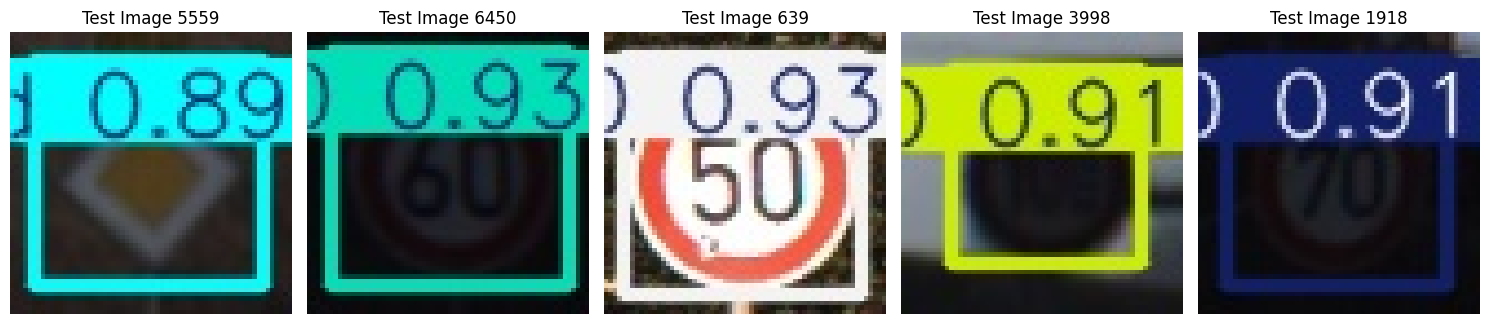

In [ ]:
import os
import shutil
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLO model
model = YOLO("/content/Model_data/bests.pt")
# Clear previous YOLO prediction folder (if exists)
predictions_dir = "runs/detect/predict"
if os.path.exists(predictions_dir):
    shutil.rmtree(predictions_dir)  # Delete old predictions
    print("Deleted previous YOLO predictions.")

# Load X_test.npy
X_test = np.load("/content/Chkpt1/X_test.npy")

# Number of images to test
num_test_images = 5

# Randomly select test images
random_indices = random.sample(range(len(X_test)), num_test_images)

# Temporary folder for saving test images
temp_dir = "/content/test_predictions"
os.makedirs(temp_dir, exist_ok=True)

# Run YOLO inference on randomly selected images
for i, idx in enumerate(random_indices):
    test_img = (X_test[idx] * 255).astype(np.uint8)

    # Save the image temporarily
    img_path = f"{temp_dir}/test_{i}.jpg"
    cv2.imwrite(img_path, cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR))

    # Run YOLO inference
    model.predict(source=img_path, save=True, conf=0.5)

    # Delete the temporary image after inference
    os.remove(img_path)

    print(f"Processed and deleted Image {i} (Index: {idx})")

# Get the latest predictions folder (should be "runs/detect/predict")
output_images = sorted(os.listdir(predictions_dir))[:num_test_images]  # Sorted to match order

# Display results
plt.figure(figsize=(15, 5))

for i, img_name in enumerate(output_images):
    output_path = os.path.join(predictions_dir, img_name)

    # Load the detected image
    output_image = cv2.imread(output_path)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Plot the image with a title showing the selected index
    plt.subplot(1, num_test_images, i + 1)
    plt.imshow(output_image)
    plt.title(f"Test Image {random_indices[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Evaluation

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

# Load YOLO model
model = YOLO("/content/Model_data/bests.pt")

# Load X_test.npy and y_test.npy
X_test = np.load("/content/Chkpt1/X_test.npy")
y_test = np.load("/content/Chkpt1/y_test.npy")

# Ensure the folder is fresh before running inference
predictions_dir = "runs/detect/predict"
if os.path.exists(predictions_dir):
    shutil.rmtree(predictions_dir)
    print("Deleted previous YOLO predictions.")

# Run YOLO inference on all test images
yolo_predictions = []  # Store predicted class labels

for i in tqdm(range(len(X_test)), desc="Running YOLO Inference"):
    test_img = (X_test[i] * 255).astype(np.uint8)

    # Save the test image temporarily
    img_path = f"/content/temp_test.jpg"
    cv2.imwrite(img_path, cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR))

    # Run YOLO inference
    results = model.predict(source=img_path, conf=0.5, verbose=False)

    # Extract the predicted class ID (if detection exists)
    if results[0].boxes.cls.shape[0] > 0:
        predicted_class = int(results[0].boxes.cls[0].item())  # Get first detected class
    else:
        predicted_class = -1  # No detection

    yolo_predictions.append(predicted_class)

# Convert predictions to numpy array and save
yolo_predictions = np.array(yolo_predictions)
np.save("/content/Chkpt1/yolo_predictions.npy", yolo_predictions)

print("YOLO Predictions saved successfully!")


Deleted previous YOLO predictions.


Running YOLO Inference: 100%|██████████| 12630/12630 [06:24<00:00, 32.88it/s]

YOLO Predictions saved successfully!


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Load ground truth and predictions
y_test = np.load("/content/Chkpt1/y_test.npy")
yolo_predictions = np.load("/content/Chkpt1/yolo_predictions.npy")

# Filter out cases where YOLO didn't detect anything
valid_indices = yolo_predictions != -1  # Remove no-detection cases
y_test_filtered = y_test[valid_indices]
yolo_predictions_filtered = yolo_predictions[valid_indices]

# Compute accuracy
accuracy = accuracy_score(y_test_filtered, yolo_predictions_filtered)

# Compute precision, recall, and f1-score
report = classification_report(y_test_filtered, yolo_predictions_filtered, digits=4)

# Display Results
print(f"Model Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n", report)


Model Accuracy: 3.86%

Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        59
           1     0.0605    0.0651    0.0627       676
           2     0.0642    0.0678    0.0659       708
           3     0.0346    0.0375    0.0360       427
           4     0.0532    0.0566    0.0548       601
           5     0.0427    0.0471    0.0448       573
           6     0.0148    0.0142    0.0145       141
           7     0.0226    0.0243    0.0234       411
           8     0.0336    0.0340    0.0338       412
           9     0.0296    0.0323    0.0309       433
          10     0.0483    0.0474    0.0478       612
          11     0.0338    0.0375    0.0356       373
          12     0.0547    0.0619    0.0581       630
          13     0.0647    0.0695    0.0670       662
          14     0.0215    0.0315    0.0256       254
          15     0.0048    0.0051    0.0050       195
          16     0.0267    0.0294 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np

yolo_predictions = np.load("/content/Chkpt1/yolo_predictions.npy")

# Count how many images had a detection (not -1)
num_detected = np.sum(yolo_predictions != -1)
num_total = len(yolo_predictions)

print(f"✅ YOLO detected at least one object in {num_detected} / {num_total} images.")


✅ YOLO detected at least one object in 11667 / 12630 images.


In [ ]:
y_test = np.load("/content/Chkpt1/y_test.npy")
yolo_predictions = np.load("/content/Chkpt1/yolo_predictions.npy")

# Show first 20 comparisons
print("🧐 Comparing YOLO predictions vs. ground truth labels:")
for i in range(20):
    print(f"Image {i}: YOLO predicted {yolo_predictions[i]} | Ground Truth {y_test[i]}")


🧐 Comparing YOLO predictions vs. ground truth labels:
Image 0: YOLO predicted 30 | Ground Truth 16
Image 1: YOLO predicted 4 | Ground Truth 1
Image 2: YOLO predicted -1 | Ground Truth 38
Image 3: YOLO predicted 24 | Ground Truth 33
Image 4: YOLO predicted 3 | Ground Truth 11
Image 5: YOLO predicted 9 | Ground Truth 38
Image 6: YOLO predicted 23 | Ground Truth 18
Image 7: YOLO predicted 1 | Ground Truth 12
Image 8: YOLO predicted 17 | Ground Truth 25
Image 9: YOLO predicted 35 | Ground Truth 35
Image 10: YOLO predicted 4 | Ground Truth 12
Image 11: YOLO predicted 9 | Ground Truth 7
Image 12: YOLO predicted 1 | Ground Truth 23
Image 13: YOLO predicted 13 | Ground Truth 7
Image 14: YOLO predicted 14 | Ground Truth 4
Image 15: YOLO predicted 14 | Ground Truth 9
Image 16: YOLO predicted 9 | Ground Truth 21
Image 17: YOLO predicted 7 | Ground Truth 20
Image 18: YOLO predicted 42 | Ground Truth 27
Image 19: YOLO predicted 24 | Ground Truth 38


In [ ]:
yaml_path = "/content/dataset.yaml"  # Update with your actual path

with open(yaml_path, "r") as file:
    data = file.readlines()

print("📂 Class Names in dataset.yaml:")
for line in data:
    print(line.strip())


📂 Class Names in dataset.yaml:

path: /content
train: YOLO_Labels  # Folder containing training labels
val: YOLO_Labels  # Using the same for validation
nc: 43  # Number of traffic sign classes
names: ['Speed Limit 20', 'Speed Limit 30', 'Speed Limit 50', 'Speed Limit 60',
'Speed Limit 70', 'Speed Limit 80', 'End of Speed Limit 80', 'Speed Limit 100',
'Speed Limit 120', 'No Overtaking', 'No Overtaking Trucks', 'Right of Way Intersection',
'Priority Road', 'Yield', 'Stop', 'No Vehicles', 'No Trucks', 'No Entry',
'Caution', 'Dangerous Left Curve', 'Dangerous Right Curve', 'Double Curve',
'Bumpy Road', 'Slippery Road', 'Road Narrows on Right', 'Road Work',
'Traffic Signals', 'Pedestrian Crossing', 'Children Crossing', 'Bicycles Crossing',
'Snow Warning', 'Deer Warning', 'End of Speed & Overtaking Limits', 'Turn Right',
'Turn Left', 'Ahead Only', 'Go Right or Straight', 'Go Left or Straight',
'Keep Right', 'Keep Left', 'Roundabout Mandatory', 'End of No Passing',
'End of No Passing for Tru

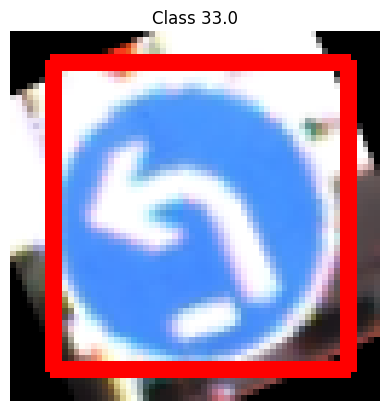

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load augmented images
X_train_aug = np.load("/content/Chkpt2/X_train_aug.npy")

# Pick a random sample index
idx = np.random.randint(0, len(X_train_aug))

# Load corresponding label
label = y_train_aug_yolo[idx]

# Extract bounding box details
class_id, x_center, y_center, width, height = label

# Convert x_center, y_center, width, height from YOLO format to pixel values
img_height, img_width, _ = X_train_aug[idx].shape
x_min = int((x_center - width / 2) * img_width)
y_min = int((y_center - height / 2) * img_height)
x_max = int((x_center + width / 2) * img_width)
y_max = int((y_center + height / 2) * img_height)

# Plot the image with bounding box
img = (X_train_aug[idx] * 255).astype(np.uint8)
img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

plt.imshow(img)
plt.title(f"Class {class_id}")
plt.axis("off")
plt.show()


<ipython-input-37-2d4a31c3b51a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


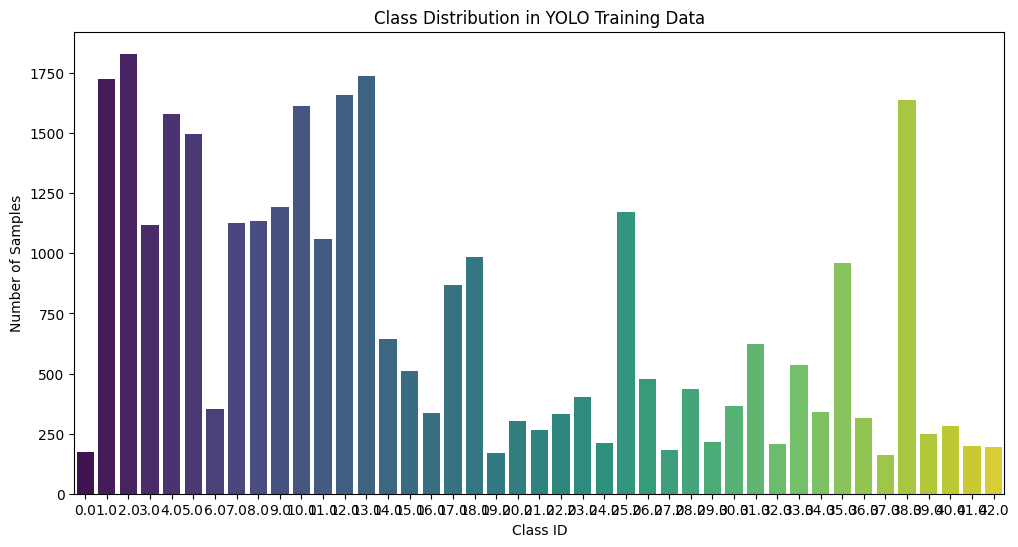

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each class
unique, counts = np.unique(y_train_yolo[:, 0], return_counts=True)

# Plot distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in YOLO Training Data")
plt.show()

In [ ]:
import numpy as np

# Load ground truth and YOLO predictions
y_test = np.load("/content/Chkpt1/y_test.npy")
yolo_predictions = np.load("/content/Chkpt1/yolo_predictions.npy")

# Check shapes
print(f"📊 y_test shape: {y_test.shape}")
print(f"📊 yolo_predictions shape: {yolo_predictions.shape}")

# Compare first 20 labels
for i in range(20):
    print(f"Image {i}: Ground Truth = {y_test[i]} | YOLO Prediction = {yolo_predictions[i]}")

📊 y_test shape: (12630,)
📊 yolo_predictions shape: (12630,)
Image 0: Ground Truth = 16 | YOLO Prediction = 30
Image 1: Ground Truth = 1 | YOLO Prediction = 4
Image 2: Ground Truth = 38 | YOLO Prediction = -1
Image 3: Ground Truth = 33 | YOLO Prediction = 24
Image 4: Ground Truth = 11 | YOLO Prediction = 3
Image 5: Ground Truth = 38 | YOLO Prediction = 9
Image 6: Ground Truth = 18 | YOLO Prediction = 23
Image 7: Ground Truth = 12 | YOLO Prediction = 1
Image 8: Ground Truth = 25 | YOLO Prediction = 17
Image 9: Ground Truth = 35 | YOLO Prediction = 35
Image 10: Ground Truth = 12 | YOLO Prediction = 4
Image 11: Ground Truth = 7 | YOLO Prediction = 9
Image 12: Ground Truth = 23 | YOLO Prediction = 1
Image 13: Ground Truth = 7 | YOLO Prediction = 13
Image 14: Ground Truth = 4 | YOLO Prediction = 14
Image 15: Ground Truth = 9 | YOLO Prediction = 14
Image 16: Ground Truth = 21 | YOLO Prediction = 9
Image 17: Ground Truth = 20 | YOLO Prediction = 7
Image 18: Ground Truth = 27 | YOLO Prediction 

In [ ]:
# Count -1 values
num_ignored = np.sum(yolo_predictions == -1)

print(f"❌ Number of Images Where YOLO Predicted Nothing (-1): {num_ignored}")

❌ Number of Images Where YOLO Predicted Nothing (-1): 963


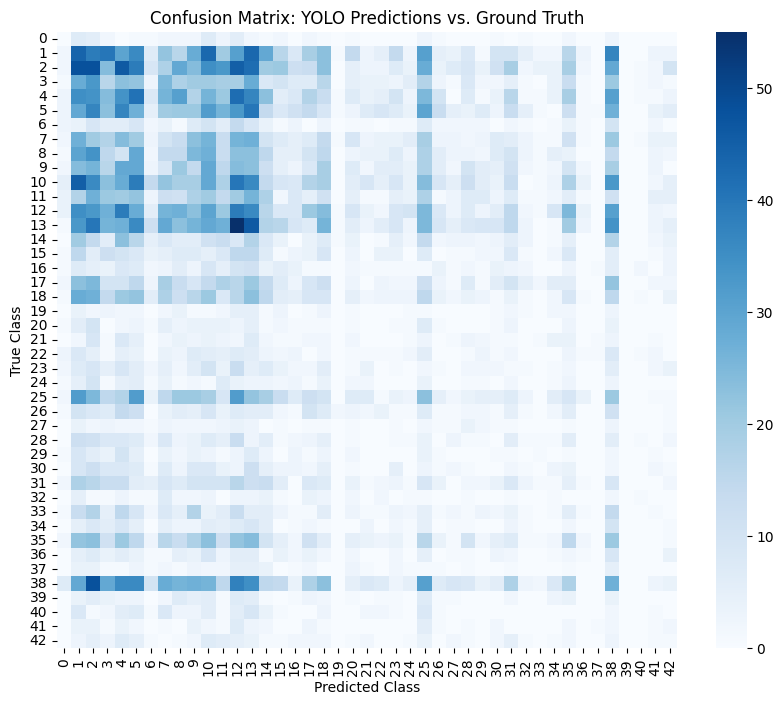

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Remove -1 values (ignored images)
valid_indices = yolo_predictions != -1
y_test_filtered = y_test[valid_indices]
yolo_predictions_filtered = yolo_predictions[valid_indices]

# Compute confusion matrix
cm = confusion_matrix(y_test_filtered, yolo_predictions_filtered)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", annot=False, fmt="d")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix: YOLO Predictions vs. Ground Truth")
plt.show()


In [ ]:
from collections import Counter

# Get (true, predicted) pairs
errors = list(zip(y_test_filtered, yolo_predictions_filtered))
error_counts = Counter(errors)

# Print the most common mistakes
print("🔍 Top 10 Most Common Misclassifications:")
for (true_label, pred_label), count in error_counts.most_common(10):
    print(f"❌ True Class {true_label} → Predicted {pred_label} ({count} times)")


🔍 Top 10 Most Common Misclassifications:
❌ True Class 13 → Predicted 12 (55 times)
❌ True Class 2 → Predicted 2 (48 times)
❌ True Class 38 → Predicted 2 (48 times)
❌ True Class 2 → Predicted 1 (48 times)
❌ True Class 2 → Predicted 4 (46 times)
❌ True Class 13 → Predicted 13 (46 times)
❌ True Class 10 → Predicted 1 (45 times)
❌ True Class 2 → Predicted 12 (45 times)
❌ True Class 1 → Predicted 1 (44 times)
❌ True Class 1 → Predicted 10 (43 times)


In [ ]:
results = model.predict(source=img_path, conf=0.2, verbose=False)

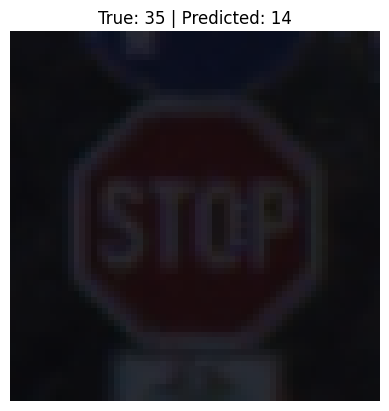

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load test images & labels
X_test = np.load("/content/Chkpt1/X_test.npy")
y_test = np.load("/content/Chkpt1/y_test.npy")
yolo_predictions = np.load("/content/Chkpt1/yolo_predictions.npy")

# Pick a random index
idx = np.random.randint(0, len(X_test))

# Load test image
test_img = (X_test[idx] * 255).astype(np.uint8)

# Get ground truth & prediction
true_label = y_test[idx]
predicted_label = yolo_predictions[idx]

# Display image with labels
plt.imshow(test_img)
plt.title(f"True: {true_label} | Predicted: {predicted_label}")
plt.axis("off")
plt.show()


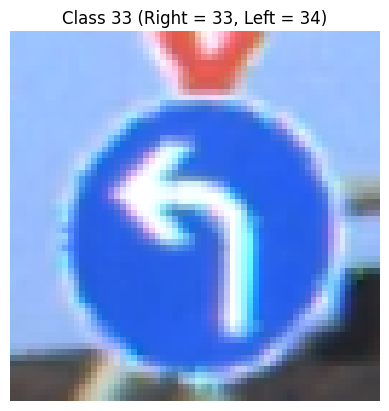

In [ ]:
# Pick a sample left or right turn sign
idx = np.random.choice(np.where((y_test == 33) | (y_test == 34))[0])  # Class 33 = Right Turn, 34 = Left Turn

# Load the test image
test_img = (X_test[idx] * 255).astype(np.uint8)

# Show image
plt.imshow(test_img)
plt.title(f"Class {y_test[idx]} (Right = 33, Left = 34)")
plt.axis("off")
plt.show()


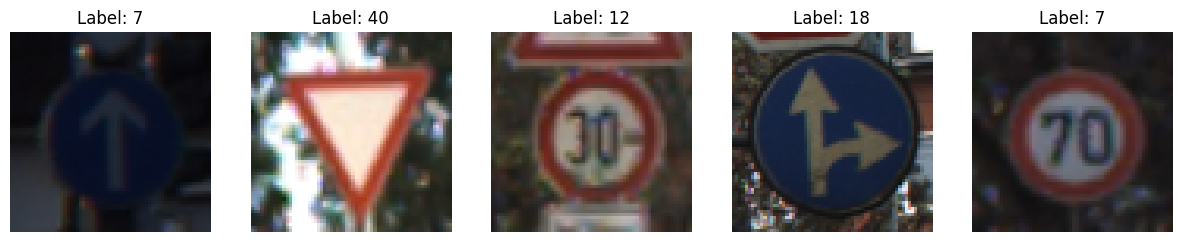

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load test images and labels
X_test = np.load("/content/Chkpt1/X_test.npy")
y_test = np.load("/content/Chkpt1/y_test.npy")

# Pick multiple random indices to compare
indices = np.random.choice(len(X_test), 5, replace=False)

# Display images with labels
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(1, 5, i + 1)
    img = (X_test[idx] * 255).astype(np.uint8)
    plt.imshow(img)
    plt.title(f"Label: {y_test[idx]}")
    plt.axis("off")
plt.show()


In [ ]:
import pandas as pd

# Load the Test.csv file (update the path if needed)
test_csv_path = "/content/GTSRB_Data/Test.csv"
df_test = pd.read_csv(test_csv_path)

# Extract class labels in the correct order
y_test_fixed = df_test["ClassId"].values  # Ensure it matches X_test

# Save corrected labels
np.save("/content/Chkpt1/y_test1.npy", y_test_fixed)

print(f"✅ y_test.npy regenerated successfully! Shape: {y_test_fixed.shape}")


✅ y_test.npy regenerated successfully! Shape: (12630,)


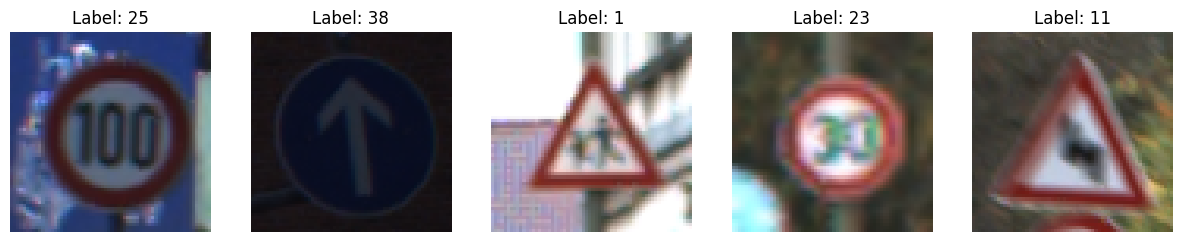

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load test images and labels
X_test = np.load("/content/Chkpt1/X_test.npy")
y_test = np.load("/content/Chkpt1/y_test1.npy")

# Pick multiple random indices to compare
indices = np.random.choice(len(X_test), 5, replace=False)

# Display images with labels
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(1, 5, i + 1)
    img = (X_test[idx] * 255).astype(np.uint8)
    plt.imshow(img)
    plt.title(f"Label: {y_test[idx]}")
    plt.axis("off")
plt.show()
